In [ ]:
# Install the required modules.
!pip install yfinance
!pip install ta

In [ ]:
# Import the required libraries.
import yfinance as yf
import ta
import pandas as pd
from datetime import date, timedelta, datetime
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
ticker = 'RELIANCE.NS'
start_date = '2021-01-01'
end_date = '2023-05-22'

date_fmt = '%Y-%m-%d'

In [ ]:
start_date_buffer = datetime.strptime(start_date, date_fmt) - timedelta(days=365) # Inputs a string and convert it into a datetime object according to the specified date format.
start_date_buffer = start_date_buffer.strftime(date_fmt)
start_date_buffer

df = yf.download(ticker, start=start_date_buffer, end=end_date)
k_band = ta.volatility.KeltnerChannel(df.High, df.Low, df.Close, 10)

df['K_BAND_UB'] = k_band.keltner_channel_hband().round(4)
df['K_BAND_LB'] = k_band.keltner_channel_lband().round(4)

df[['K_BAND_UB', 'K_BAND_LB']].dropna().head()

df['CLOSE_PREV'] = df.Close.shift(1)

df['LONG'] = (df.Close <= df.K_BAND_LB) & (df.CLOSE_PREV > df.K_BAND_LB)
df['EXIT_LONG'] = (df.Close >= df.K_BAND_UB) & (df.CLOSE_PREV < df.K_BAND_UB)

df['SHORT'] = (df.Close >= df.K_BAND_UB) & (df.CLOSE_PREV < df.K_BAND_UB)
df['EXIT_SHORT'] = (df.Close <= df.K_BAND_LB) & (df.CLOSE_PREV > df.K_BAND_LB)

df.LONG = df.LONG.shift(1)
df.EXIT_LONG = df.EXIT_LONG.shift(1)
df.SHORT = df.SHORT.shift(1)
df.EXIT_SHORT = df.EXIT_SHORT.shift(1)

df[['LONG', 'EXIT_LONG', 'SHORT', 'EXIT_SHORT']].dropna().head()

bt_df = df[(df.index >= start_date) & (df.index <= end_date)]

[*********************100%***********************]  1 of 1 completed


In [ ]:
def strategy_BollingerBands(df, **kwargs):
  n = kwargs.get('n', 10)
  n_rng = kwargs.get('n_rng', 2)
  data = df.copy()

  boll = ta.volatility.BollingerBands(data.Close, n, n_rng)

  data['BOLL_LBAND_INDI'] = boll.bollinger_lband_indicator()
  data['BOLL_UBAND_INDI'] = boll.bollinger_hband_indicator()

  data['CLOSE_PREV'] = data.Close.shift(1)

  data['LONG'] = data.BOLL_LBAND_INDI == 1
  data['EXIT_LONG'] = data.BOLL_UBAND_INDI == 1

  data['SHORT'] = data.BOLL_UBAND_INDI == 1
  data['EXIT_SHORT'] = data.BOLL_LBAND_INDI == 1

  data.LONG = data.LONG.shift(1)
  data.EXIT_LONG = data.EXIT_LONG.shift(1)
  data.SHORT = data.SHORT.shift(1)
  data.EXIT_SHORT = data.EXIT_SHORT.shift(1)

  return data

In [ ]:
def get_stock_backtest_data(ticker, start_date, end_date):
  date_fmt = '%Y-%m-%d'

  start_date_buffer = datetime.strptime(start_date, date_fmt) - timedelta(days=365)
  start_date_buffer = start_date_buffer.strftime(date_fmt)

  df = yf.download(ticker, start=start_date_buffer, end=end_date)

  return df

def prepare_stock_ta_backtest_data(df, start_date, end_date, strategy, **strategy_params):
  df_strategy = strategy(df, **strategy_params)
  bt_df = df_strategy[(df_strategy.index >= start_date) & (df_strategy.index <= end_date)]
  return bt_df

df = get_stock_backtest_data('RELIANCE.NS', start_date, end_date)
bt_df = prepare_stock_ta_backtest_data(
    df, start_date, end_date, strategy_BollingerBands, n = 10, n_rng = 2)


[*********************100%***********************]  1 of 1 completed


In [ ]:
def run_stock_ta_backtest(bt_df, stop_loss_lvl=None):
  balance = 1000000
  pnl = 0
  position = 0

  last_signal = 'hold'
  last_price = 0
  c = 0

  trade_date_start = []
  trade_date_end = []
  trade_days = []
  trade_side = []
  trade_pnl = []
  trade_ret = []

  cum_value = []

  for index, row in bt_df.iterrows():
      # check and close any positions
      if row.EXIT_LONG and last_signal == 'long':
        trade_date_end.append(row.name)
        trade_days.append(c)

        pnl = (row.Open - last_price) * position
        trade_pnl.append(pnl)
        trade_ret.append((row.Open / last_price - 1) * 100)

        balance = balance + row.Open * position

        position = 0
        last_signal = 'hold'

        c = 0

      elif row.EXIT_SHORT and last_signal == 'short':
        trade_date_end.append(row.name)
        trade_days.append(c)

        pnl = (row.Open - last_price) * position
        trade_pnl.append(pnl)
        trade_ret.append((last_price / row.Open - 1) * 100)

        balance = balance + pnl

        position = 0
        last_signal = 'hold'

        c = 0


      # check signal and enter any possible position
      if row.LONG and last_signal != 'long':
        last_signal = 'long'
        last_price = row.Open
        trade_date_start.append(row.name)
        trade_side.append('long')

        position = int(balance / row.Open)
        cost = position * row.Open
        balance = balance - cost

        c = 0

      elif row.SHORT and last_signal != 'short':
        last_signal = 'short'
        last_price = row.Open
        trade_date_start.append(row.name)
        trade_side.append('short')

        position = int(balance / row.Open) * -1

        c = 0

      if stop_loss_lvl:
        # check stop loss
        if last_signal == 'long' and (row.Low / last_price - 1) * 100 <= stop_loss_lvl:
          c = c + 1

          trade_date_end.append(row.name)
          trade_days.append(c)

          stop_loss_price = last_price + round(last_price * (stop_loss_lvl / 100), 4)

          pnl = (stop_loss_price - last_price) * position
          trade_pnl.append(pnl)
          trade_ret.append((stop_loss_price / last_price - 1) * 100)

          balance = balance + stop_loss_price * position

          position = 0
          last_signal = 'hold'

          c = 0

        elif last_signal == 'short' and (last_price / row.Low - 1) * 100 <= stop_loss_lvl:
          c = c + 1

          trade_date_end.append(row.name)
          trade_days.append(c)

          stop_loss_price = last_price - round(last_price * (stop_loss_lvl / 100), 4)

          pnl = (stop_loss_price - last_price) * position
          trade_pnl.append(pnl)
          trade_ret.append((last_price / stop_loss_price - 1) * 100)

          balance = balance + pnl

          position = 0
          last_signal = 'hold'

          c = 0


      # compute market value and count days for any possible poisition
      if last_signal == 'hold':
        market_value = balance
      elif last_signal == 'long':
        c = c + 1
        market_value = position * row.Close + balance
      else:
        c = c + 1
        market_value = (row.Close - last_price) * position + balance

      cum_value.append(market_value)


  # generate analysis
  # performance over time
  cum_ret_df = pd.DataFrame(cum_value, index=bt_df.index, columns=['CUM_RET'])
  cum_ret_df['CUM_RET'] = (cum_ret_df.CUM_RET / 1000000 - 1) * 100
  cum_ret_df['BUY_HOLD'] = (bt_df.Close / bt_df.Open.iloc[0] - 1) * 100
  cum_ret_df['ZERO'] = 0

  # trade stats
  size = min(len(trade_date_start), len(trade_date_end))

  tarde_dict = {
      'START': trade_date_start[:size],
      'END': trade_date_end[:size],
      'SIDE': trade_side[:size],
      'DAYS': trade_days[:size],
      'PNL': trade_pnl[:size],
      'RET': trade_ret[:size]
  }

  trade_df = pd.DataFrame(tarde_dict)

  num_trades = trade_df.groupby('SIDE').count()[['START']]
  num_trades_win = trade_df[trade_df.PNL > 0].groupby('SIDE').count()[['START']]

  avg_days = trade_df.groupby('SIDE').mean(numeric_only = True)[['DAYS']]

  avg_ret = trade_df.groupby('SIDE').mean(numeric_only = True)[['RET']]
  avg_ret_win = trade_df[trade_df.PNL > 0].groupby('SIDE').mean(numeric_only = True)[['RET']]
  avg_ret_loss = trade_df[trade_df.PNL < 0].groupby('SIDE').mean(numeric_only = True)[['RET']]

  std_ret = trade_df.groupby('SIDE').std(numeric_only = True)[['RET']]

  detail_df = pd.concat([
                        num_trades, num_trades_win, avg_days,
                        avg_ret, avg_ret_win, avg_ret_loss, std_ret
                        ], axis=1, sort=False)

  detail_df.columns = [
                      'NUM_TRADES', 'NUM_TRADES_WIN', 'AVG_DAYS',
                      'AVG_RET', 'AVG_RET_WIN', 'AVG_RET_LOSS', 'STD_RET'
                      ]

  detail_df.round(2)

  # max drawdown
  mv_df = pd.DataFrame(cum_value, index=bt_df.index, columns=['MV'])

  days = len(mv_df)

  roll_max = mv_df.MV.rolling(window=days, min_periods=1).max()
  drawdown_val = mv_df.MV - roll_max
  drawdown_pct = (mv_df.MV / roll_max - 1) * 100

  # return all stats
  return {
      'cum_ret_df': cum_ret_df,
      'max_drawdown': {
          'value': round(drawdown_val.min(), 0),
          'pct': round(drawdown_pct.min(), 2),
          'list': drawdown_pct
          },
      'trade_stats': detail_df,
      'trade_dict' : tarde_dict
  }

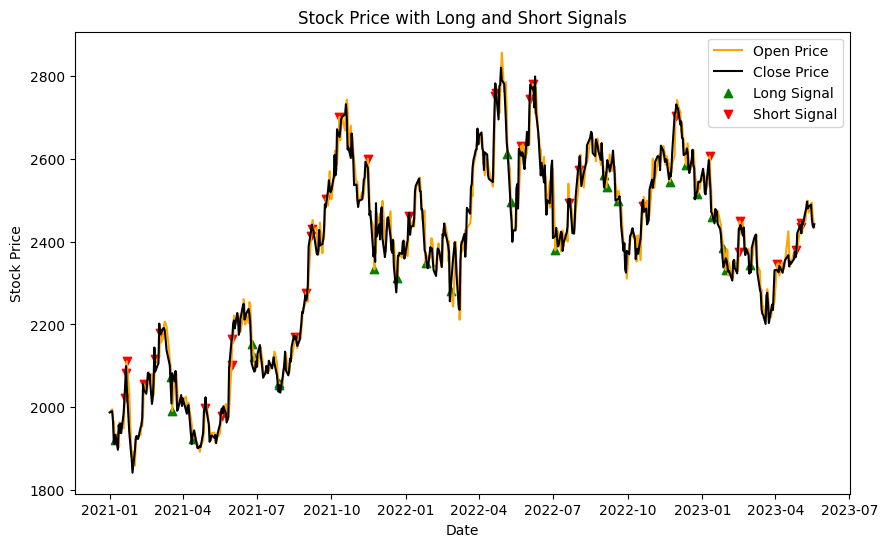

In [ ]:
df_subset = bt_df[['Open','Close', 'LONG', 'SHORT']].dropna()

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the stock prices
plt.plot(df_subset.index, df_subset['Open'], color='Orange', label='Open Price')
plt.plot(df_subset.index, df_subset['Close'], color='black', label='Close Price')

# Plot the long signals
long_mask = df_subset['LONG'].where(df_subset['LONG'] == True).dropna()
plt.scatter(long_mask.index, df_subset['Open'][long_mask.index], color='green', marker='^', label='Long Signal')

# Plot the short signals
short_mask = df_subset['SHORT'].where(df_subset['SHORT'] == True).dropna()
plt.scatter(short_mask.index, df_subset['Open'][short_mask.index], color='red', marker='v', label='Short Signal')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price with Long and Short Signals')

# Add legend
plt.legend()

# Display the plot
plt.show()


Max Drawdown: -40.65 %


,NUM_TRADES,NUM_TRADES_WIN,AVG_DAYS,AVG_RET,AVG_RET_WIN,AVG_RET_LOSS,STD_RET
SIDE,,,,,,,
long,12,9,23.666667,2.609559,4.581318,-3.305716,5.762917
short,11,6,24.545455,0.996460,5.443694,-4.340221,5.761995


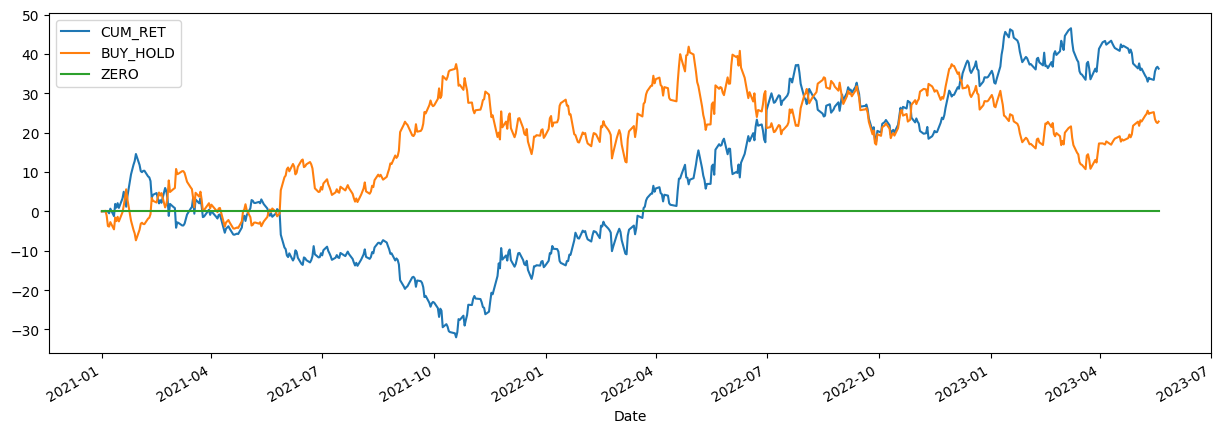

In [ ]:
result = run_stock_ta_backtest(bt_df)
result['cum_ret_df'].plot(figsize=(15, 5))
print('Max Drawdown:', result['max_drawdown']['pct'], '%')
display(result['trade_stats'])

<BarContainer object of 589 artists>

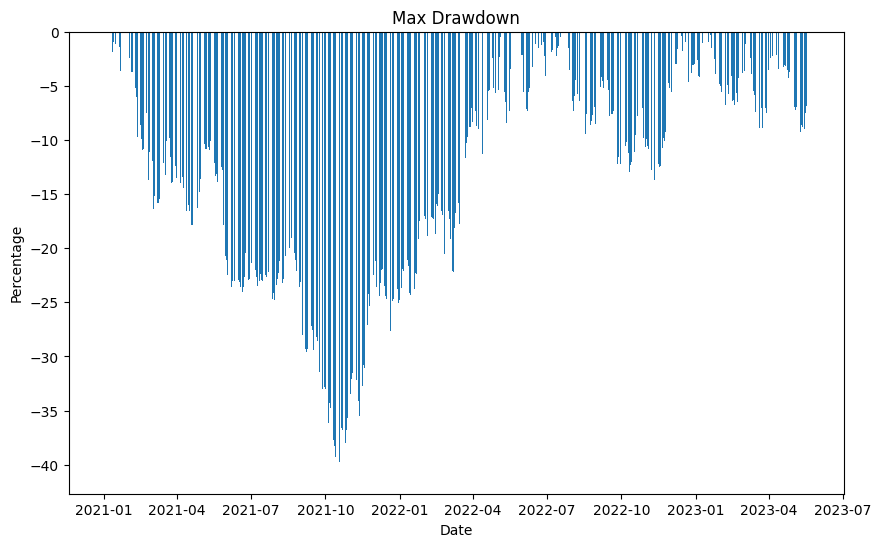

In [ ]:
# df_subset = bt_df[['Open','Close', 'LONG', 'SHORT']].dropna()

plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.title('Max Drawdown')
plt.bar(result['max_drawdown']['list'].index,result['max_drawdown']['list'])

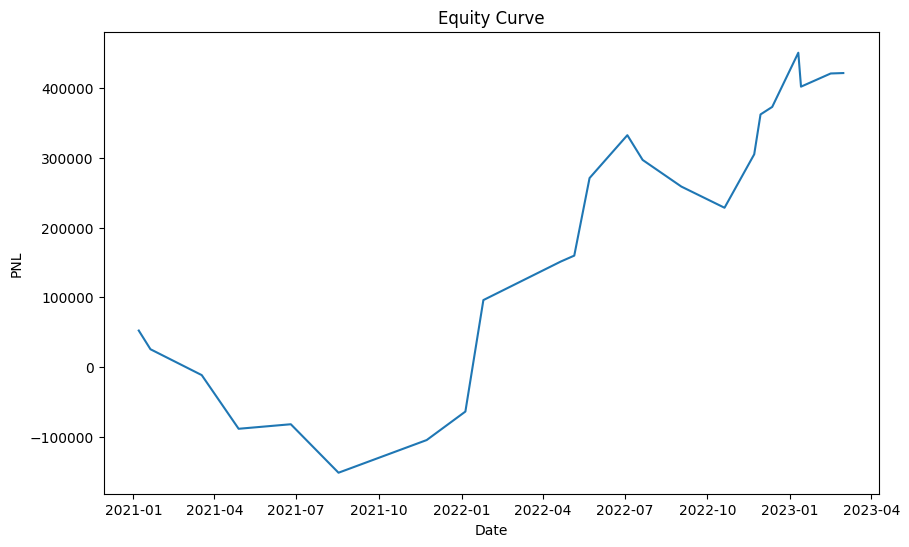

In [ ]:
import numpy as np
def cumulative_sum(input_list):
    # Convert the list to a NumPy array
    input_array = np.array(input_list)
    # Compute the cumulative sum along the first axis of the array
    cumulative_sum_array = np.cumsum(input_array)
    # Convert the NumPy array back to a list and return it
    return cumulative_sum_array.tolist()

plt.figure(figsize=(10, 6))
output = cumulative_sum(result['trade_dict']['PNL'])
plt.xlabel('Date')
plt.ylabel('PNL')
plt.title('Equity Curve')
plt.plot(result['trade_dict']['START'], output)